
# Visualize every Player Gaze

In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

import os
from pandas import DataFrame
import pandas as pd
from notebook_utils import NotebookUtilities
import matplotlib.pyplot as plt
import re
import humanize
from datetime import timedelta

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))

In [3]:

# Get all CSVs into one data frame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape) # (842663, 112)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(829277, 113)



#### Visualize the patients gazed at in on one scene's timeline

In [5]:

nu.get_regexed_columns(frvrs_logs_df, search_regex=re.compile('gaze', re.IGNORECASE))

['action_type', 'voice_capture_message']

In [8]:

nu.get_regexed_dataframe(frvrs_logs_df, ['action_type'], search_regex=re.compile('gaze', re.IGNORECASE)).dropna(axis='columns', how='all').T

,809968
action_type,PLAYER_GAZE
elapsed_time,123331
event_time,2023-09-07 14:43:39
session_uuid,0b630a14-5acd-4e11-99df-8f59d804f807
file_name,v.1.3/0b630a14-5acd-4e11-99df-8f59d804f807.csv
logger_version,1.3
scene_index,0
player_gaze_location,"(2.9, 0.0, 2.5)"
player_gaze_patient_id,Military Mike Jungle Combat_2_0 Root
player_gaze_distance_to_patient,1.898079


In [111]:

mask_series = (frvrs_logs_df.action_type.isin(['PLAYER_GAZE']))
mask_series &= ~frvrs_logs_df.player_gaze_patient_id.isnull()
multiindex_dict = {}
multiindex = frvrs_logs_df[mask_series].groupby(['session_uuid', 'scene_index']).player_gaze_patient_id.nunique().sort_values().tail(1).index
for name in multiindex.names: multiindex_dict[name] = multiindex.get_level_values(name)[0]
multiindex_dict

{'session_uuid': 'd9d58da9-9bdc-41ea-90fe-4c84db4635d9', 'scene_index': 0}

In [108]:

def get_max_salt(session_uuid, scene_index, random_patient_id=None):
    scene_mask_series = (frvrs_logs_df.session_uuid == session_uuid) & (frvrs_logs_df.scene_index == scene_index)
    
    # Get a random patient from within the scene
    if random_patient_id is None: random_patient_id = random.choice(frvrs_logs_df[scene_mask_series].patient_id.unique())

    # Get the patient data frame
    mask_series = scene_mask_series & (frvrs_logs_df.patient_id == random_patient_id)
    patient_df = frvrs_logs_df[mask_series]
    
    # Get the max salt value
    max_salt = fu.get_max_salt(patient_df)

    return random_patient_id, max_salt

In [117]:

scene_mask_series = (frvrs_logs_df.session_uuid == multiindex_dict['session_uuid']) & (frvrs_logs_df.scene_index == multiindex_dict['scene_index'])
scene_df = frvrs_logs_df[scene_mask_series]
patient_color_dict = {}
mask_series = ~scene_df.patient_record_salt.isnull()
for patient_id, patient_df in scene_df[mask_series].groupby('patient_id'):
    patient_color_dict[patient_id] = fu.salt_to_tag_dict[fu.get_max_salt(patient_df)]
patient_color_dict

{'Bob_1 Root': 'gray', 'Bob_10 Root': 'red', 'Bob_12 Root': 'red', 'Bob_7 Root': 'yellow', 'Gary_16 Root': 'green', 'Gary_2 Root': 'red', 'Helga_14 Root': 'red', 'Helga_17 Root': 'gray', 'Helga_6 Root': 'yellow', 'Helga_9 Root': 'green', 'Lily_0 Root': 'black', 'Lily_11 Root': 'red', 'Lily_15 Root': 'red', 'Lily_5 Root': 'red', 'Mike_13 Root': 'yellow', 'Mike_3 Root': 'red', 'Mike_4 Root': 'red', 'Mike_8 Root': 'green'}

In [114]:

from frvrs_utils import FRVRSUtilities
import os.path as osp

fu = FRVRSUtilities(
    data_folder_path=osp.abspath('../data'),
    saves_folder_path=osp.abspath('../saves')
)

In [136]:

def show_gaze_timeline(random_session_uuid=None, random_time_group=None, consecutive_cutoff=600, patient_color_dict=None, verbose=False):
    
    # Get a random session
    if random_session_uuid is None:
        mask_series = (frvrs_logs_df.action_type.isin(['PLAYER_GAZE']))
        mask_series &= ~frvrs_logs_df.player_gaze_patient_id.isnull()
        random_session_uuid = random.choice(frvrs_logs_df[mask_series].session_uuid.unique())
    
    # Get a random scene from within the session
    if random_time_group is None:
        mask_series = (frvrs_logs_df.session_uuid == random_session_uuid)
        mask_series &= (frvrs_logs_df.action_type.isin(['PLAYER_GAZE']))
        mask_series &= ~frvrs_logs_df.player_gaze_patient_id.isnull()
        random_time_group = random.choice(frvrs_logs_df[mask_series].scene_index.unique())
    
    # Get the scene mask
    scene_mask_series = (frvrs_logs_df.session_uuid == random_session_uuid) & (frvrs_logs_df.scene_index == random_time_group)
    
    # Get the elapsed time of the player gaze
    mask_series = scene_mask_series & (frvrs_logs_df.action_type.isin(['PLAYER_GAZE', 'SESSION_END', 'SESSION_START']))
    columns_list = ['elapsed_time', 'patient_id']
    patient_gazes_df = frvrs_logs_df[mask_series][columns_list].sort_values(['elapsed_time'])
    patient_gazes_df['time_diff'] = patient_gazes_df.elapsed_time.diff()
    for patient_id in patient_gazes_df.patient_id.unique():
        patient_gazes_df = replace_consecutive_rows(
            patient_gazes_df, 'patient_id', patient_id, time_diff_column='time_diff', consecutive_cutoff=consecutive_cutoff
        )
    if verbose: display(patient_gazes_df.tail(20))
    if patient_gazes_df.shape[0]:
        
        # For the patient, get a timeline of every reference of gazement
        hlineys_list = []; hlinexmins_list = []; hlinexmaxs_list = []; hlinecolors_list = []; hlinelabels_list = []
        hlineaction_types_list = []; vlinexs_list = []
        left_lim = 999999; right_lim = -999999
        
        # Get the broad horizontal line parameters
        y = 0
        hlineys_list.append(y)
        hlinecolors_list.append(plt.cm.Accent(0))
        hlinelabels_list.append('Player Gaze')
        
        # Get the fine horizontal line parameters and plot dimensions
        xmin = patient_gazes_df.elapsed_time.min(); hlinexmins_list.append(xmin);
        if xmin < left_lim: left_lim = xmin
        xmax = patient_gazes_df.elapsed_time.max(); hlinexmaxs_list.append(xmax);
        if xmax > right_lim: right_lim = xmax
        
        for row_index, row_series in patient_gazes_df.iterrows():
            # for cn in columns_list: exec(f'{cn} = row_series.{cn}')
            elapsed_time = row_series.elapsed_time
            patient_id = row_series.patient_id
            time_diff = row_series.time_diff
            
            # Get the player gaze annotation parameters
            if not pd.isna(patient_id):
                annotation_tuple = (patient_id, elapsed_time, y)
                hlineaction_types_list.append(annotation_tuple)
    
    ax = plt.figure(figsize=(18, 9)).add_subplot(1, 1, 1)
    
    # Add the timelines to the figure subplot axis
    if verbose: print(hlineys_list, hlinexmins_list, hlinexmaxs_list, hlinecolors_list)
    line_collection_obj = ax.hlines(hlineys_list, hlinexmins_list, hlinexmaxs_list, colors=hlinecolors_list)
    
    # Label each timeline with the appropriate patient name
    for label, x, y in zip(hlinelabels_list, hlinexmins_list, hlineys_list): plt.annotate(label, (x, y), textcoords='offset points', xytext=(0, -8), ha='left')
    
    # Annotate the patients who have been gazed at along their timeline
    if patient_color_dict is None:
        scene_df = frvrs_logs_df[scene_mask_series]
        patient_color_dict = {}
        mask_series = ~scene_df.patient_record_salt.isnull()
        for patient_id, patient_df in scene_df[mask_series].groupby('patient_id'):
            patient_color_dict[patient_id] = fu.salt_to_tag_dict[fu.get_max_salt(patient_df)]
    consec_regex = re.compile(r' x\d+$')
    for annotation_tuple in hlineaction_types_list:
        patient_id, x, y = annotation_tuple
        color = patient_color_dict[consec_regex.sub('', patient_id)]
        if verbose: print(patient_id, color)
        plt.annotate(patient_id, (x, y), textcoords='offset points', xytext=(0, 0), va='center', rotation=90, fontsize=7, color=color)
    
    # Mark any session boundaries with a vertical line
    ymin, ymax = ax.get_ylim()
    line_collection_obj = ax.vlines(vlinexs_list, ymin=ymin, ymax=ymax)
    
    # Remove the ticks and tick labels from the y axis
    ax.set_yticks([])
    ax.set_yticklabels([])
    
    # Move the top and right border out so that the annotations don't cross it
    # plt.subplots_adjust(top=1.5)
    # xlim_tuple = ax.set_xlim(left_lim, right_lim+10_000)
    
    # Set the title and labels
    ax.set_title(f'Player Gaze Timeline for UUID {random_session_uuid} and Scene {random_time_group}')
    ax.set_xlabel('Elapsed Time since Scene Start')
    
    # Humanize x tick labels
    xticklabels_list = []
    for text_obj in ax.get_xticklabels():
        text_obj.set_text(humanize.precisedelta(timedelta(milliseconds=text_obj.get_position()[0])).replace(', ', ',\n').replace(' and ', ' and\n'))
        xticklabels_list.append(text_obj)
    ax.set_xticklabels(xticklabels_list);

    return random_session_uuid, random_time_group

In [137]:

def replace_consecutive_rows(df, element_column, element_value, time_diff_column='time_diff', consecutive_cutoff=500):
    """
    Replaces consecutive rows in a list created from the element column with a count of how many there are in a row.
    
    Args:
        element_column: An element column from which the list of elements is created.
        element_value: The element to replace consecutive occurrences of.
        time_diff_column: the time diff column to check if the elements are close enough in time to consider "consecutive".
        consecutive_cutoff: the number of time units the time diff column must show or less.
    
    Returns:
        A DataFrame with the rows of consecutive elements replaced with one row where the
        element_value now has appended to it a count of how many rows were deleted plus one.
    """
    result_df = DataFrame([], columns=df.columns); row_index = 0; row_series = pd.Series([]); count = 0
    for row_index, row_series in df.iterrows():
        column_value = row_series[element_column]
        time_diff = row_series[time_diff_column]
        if (column_value == element_value) and (time_diff <= consecutive_cutoff):
            count += 1
            previous_row_index = row_index
            previous_row_series = row_series
        else:
            result_df.loc[row_index] = row_series
            if (count > 0):
                result_df.loc[previous_row_index] = previous_row_series
                result_df.loc[previous_row_index, element_column] = f'{element_value} x{str(count)}'
            count = 0
    
    # Handle the last element
    result_df.loc[row_index] = row_series
    if (count > 0): result_df.loc[row_index, element_column] = f'{element_value} x{str(count)}'
    
    return(result_df)

In [143]:

%matplotlib inline
import random

scene_mask_series = (frvrs_logs_df.session_uuid == multiindex_dict['session_uuid']) & (frvrs_logs_df.scene_index == multiindex_dict['scene_index'])
scene_df = frvrs_logs_df[scene_mask_series]
print([cn for cn in scene_df.columns if cn.endswith('_sort')])
patient_color_dict = {}
mask_series = ~scene_df.patient_record_sort.isnull()
sort_to_color_dict = {'still': 'black', 'waver': 'red', 'walker': 'green'}
for patient_id, patient_df in scene_df[mask_series].groupby('patient_id'):
    patient_color_dict[patient_id] = sort_to_color_dict[patient_df.patient_record_sort.max()]
patient_color_dict

['patient_demoted_sort', 'patient_record_sort', 'patient_engaged_sort']


{'Bob_1 Root': 'black', 'Bob_10 Root': 'red', 'Bob_12 Root': 'red', 'Bob_7 Root': 'red', 'Gary_16 Root': 'green', 'Gary_2 Root': 'red', 'Helga_14 Root': 'red', 'Helga_17 Root': 'black', 'Helga_6 Root': 'red', 'Helga_9 Root': 'green', 'Lily_0 Root': 'black', 'Lily_11 Root': 'green', 'Lily_15 Root': 'red', 'Lily_5 Root': 'red', 'Mike_13 Root': 'black', 'Mike_3 Root': 'black', 'Mike_4 Root': 'red', 'Mike_8 Root': 'green'}

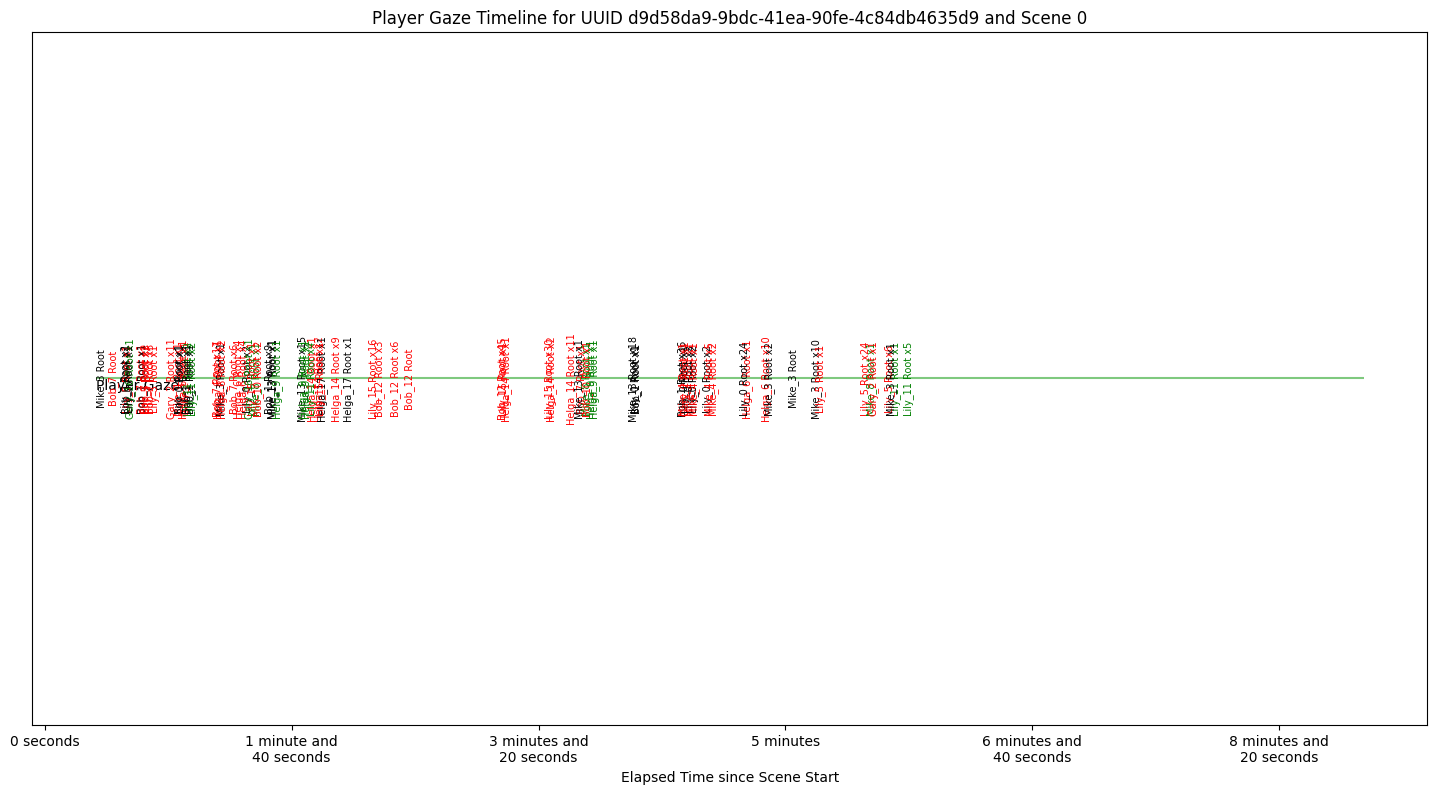

In [145]:

random_session_uuid, random_time_group = show_gaze_timeline(
    multiindex_dict['session_uuid'], multiindex_dict['scene_index'], consecutive_cutoff=5_000, patient_color_dict=patient_color_dict, verbose=False
)

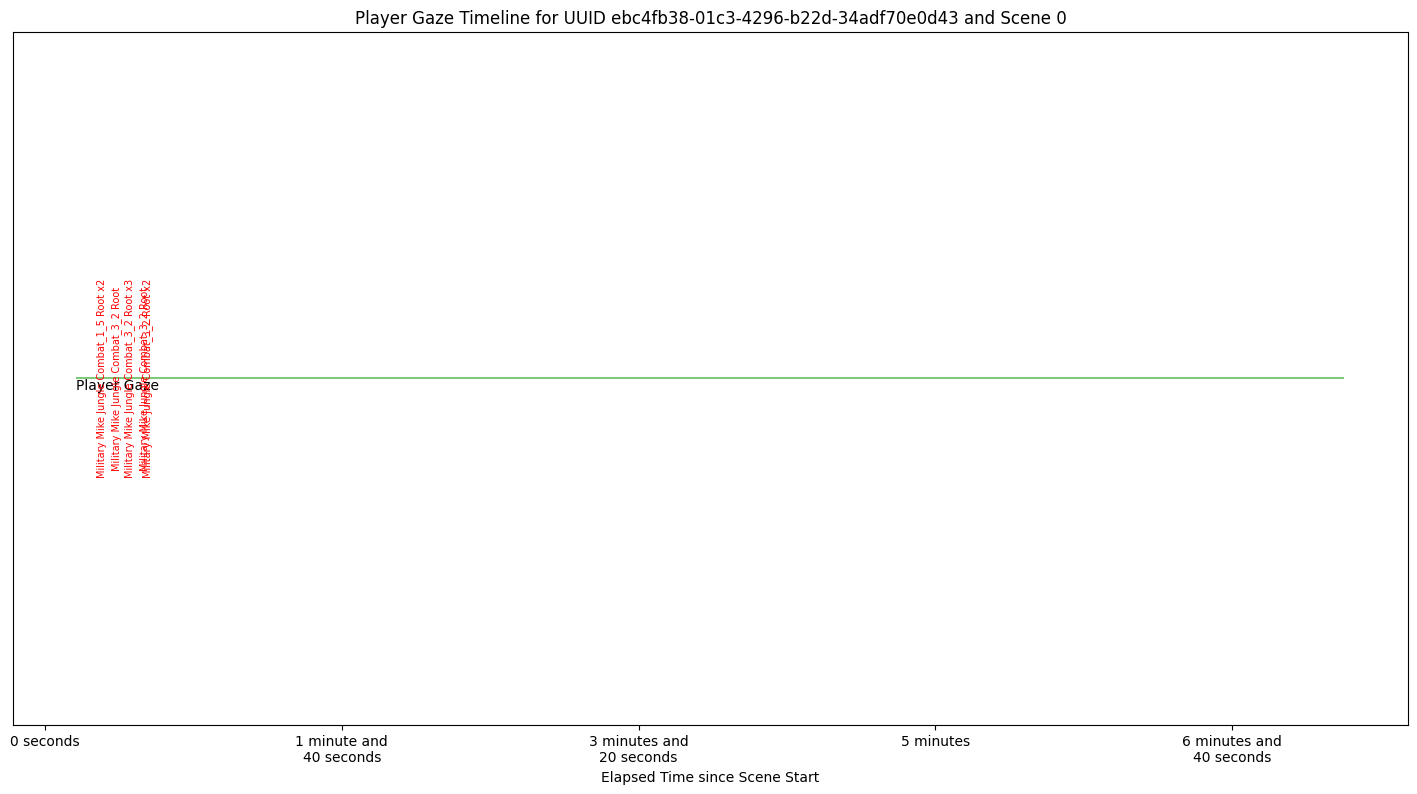

In [150]:

scene_mask_series = (frvrs_logs_df.session_uuid == random_session_uuid) & (frvrs_logs_df.scene_index == random_time_group)
scene_df = frvrs_logs_df[scene_mask_series]
patient_color_dict = {}
mask_series = ~scene_df.patient_record_sort.isnull()
sort_to_color_dict = {'still': 'black', 'waver': 'red', 'walker': 'green'}
for patient_id, patient_df in scene_df[mask_series].groupby('patient_id'):
    patient_color_dict[patient_id] = sort_to_color_dict[patient_df.patient_record_sort.max()]
random_session_uuid, random_time_group = show_gaze_timeline(
    random_session_uuid, random_time_group, consecutive_cutoff=5_000, patient_color_dict=patient_color_dict, verbose=False
)